In [125]:
import os
import gzip
import csv
import datetime as dt
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

In [5]:
RAW_DATA_PATH = 'raw_data/d12_text_station_5min_2019_10_08.txt.gz'

COLS_TO_IMPORT = list(range(0, 12))
df = pd.read_csv(RAW_DATA_PATH, compression='gzip', delimiter=',', header=None, usecols=COLS_TO_IMPORT)
cols_name = ['timestamp', 'station', 'district', 'freeway_num', 'direction', \
     'lane_type', 'station_length', 'samples', 'pct_observed', 'total_flow', \
     'avg_occupancy', 'avg_speed']
df.columns = cols_name
df.head()

,timestamp,station,district,freeway_num,direction,lane_type,station_length,samples,pct_observed,total_flow,avg_occupancy,avg_speed
0,10/08/2019 00:00:00,1201044,12,133,S,OR,NaN,0,0,NaN,NaN,NaN
1,10/08/2019 00:00:00,1201052,12,133,S,FR,NaN,10,100,0.0,0.0000,NaN
2,10/08/2019 00:00:00,1201054,12,133,S,ML,1.285,30,100,8.0,0.0038,68.8
3,10/08/2019 00:00:00,1201058,12,133,N,OR,NaN,0,0,NaN,NaN,NaN
4,10/08/2019 00:00:00,1201064,12,133,N,FR,NaN,0,0,NaN,NaN,NaN


In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [10]:
df['timestamp'] = df['timestamp'].dt.tz_localize('America/Los_Angeles')

In [11]:
df.dtypes

timestamp         datetime64[ns, America/Los_Angeles]
station                                         int64
district                                        int64
freeway_num                                     int64
direction                                      object
lane_type                                      object
station_length                                float64
samples                                         int64
pct_observed                                    int64
total_flow                                    float64
avg_occupancy                                 float64
avg_speed                                     float64
dtype: object

In [12]:
df.head()

,timestamp,station,district,freeway_num,direction,lane_type,station_length,samples,pct_observed,total_flow,avg_occupancy,avg_speed
0,2019-10-08 00:00:00-07:00,1201044,12,133,S,OR,NaN,0,0,NaN,NaN,NaN
1,2019-10-08 00:00:00-07:00,1201052,12,133,S,FR,NaN,10,100,0.0,0.0000,NaN
2,2019-10-08 00:00:00-07:00,1201054,12,133,S,ML,1.285,30,100,8.0,0.0038,68.8
3,2019-10-08 00:00:00-07:00,1201058,12,133,N,OR,NaN,0,0,NaN,NaN,NaN
4,2019-10-08 00:00:00-07:00,1201064,12,133,N,FR,NaN,0,0,NaN,NaN,NaN


In [14]:
df['lane_type'].unique()

array(['OR', 'FR', 'ML', 'HV', 'FF', 'CD', 'CH'], dtype=object)

In [16]:
# keep lane_type = ML or HV
lane_type_keep = ['ML', 'HV']
df = df[df['lane_type'].isin(lane_type_keep)]
df.head()

,timestamp,station,district,freeway_num,direction,lane_type,station_length,samples,pct_observed,total_flow,avg_occupancy,avg_speed
2,2019-10-08 00:00:00-07:00,1201054,12,133,S,ML,1.285,30,100,8.0,0.0038,68.8
5,2019-10-08 00:00:00-07:00,1201066,12,133,N,ML,0.670,20,100,11.0,0.0044,65.7
7,2019-10-08 00:00:00-07:00,1201076,12,133,N,ML,0.185,0,0,44.0,0.0292,60.9
9,2019-10-08 00:00:00-07:00,1201085,12,405,S,HV,0.180,10,100,3.0,0.0022,65.0
10,2019-10-08 00:00:00-07:00,1201087,12,405,S,ML,0.180,50,100,67.0,0.0066,72.1


In [20]:
# show the unique and the counts of unique values of timestamp
# the total 5-minute interval should be 288
print(df['timestamp'].nunique())
df['timestamp'].unique()

288


<DatetimeArray>
['2019-10-08 00:00:00-07:00', '2019-10-08 00:05:00-07:00',
 '2019-10-08 00:10:00-07:00', '2019-10-08 00:15:00-07:00',
 '2019-10-08 00:20:00-07:00', '2019-10-08 00:25:00-07:00',
 '2019-10-08 00:30:00-07:00', '2019-10-08 00:35:00-07:00',
 '2019-10-08 00:40:00-07:00', '2019-10-08 00:45:00-07:00',
 ...
 '2019-10-08 23:10:00-07:00', '2019-10-08 23:15:00-07:00',
 '2019-10-08 23:20:00-07:00', '2019-10-08 23:25:00-07:00',
 '2019-10-08 23:30:00-07:00', '2019-10-08 23:35:00-07:00',
 '2019-10-08 23:40:00-07:00', '2019-10-08 23:45:00-07:00',
 '2019-10-08 23:50:00-07:00', '2019-10-08 23:55:00-07:00']
Length: 288, dtype: datetime64[ns, America/Los_Angeles]

In [42]:
STATION_DATA_PATH = 'raw_data/d12_text_meta_2019_11_05.txt'
scols_to_keep = ['ID', 'Fwy', 'Dir', 'District', 'County', 'Abs_PM', 'Latitude', 'Longitude']
sdf =  pd.read_csv(STATION_DATA_PATH, delimiter='\t', usecols=scols_to_keep)

In [43]:
sdf.shape

(2420, 8)

In [44]:
sdf.nunique()

ID           2420
Fwy            13
Dir             4
District        1
County          1
Abs_PM        858
Latitude     1093
Longitude    1097
dtype: int64

In [45]:
sdf.head()

,ID,Fwy,Dir,District,County,Abs_PM,Latitude,Longitude
0,1201044,133,S,12,59,8.991,33.661840,-117.755300
1,1201052,133,S,12,59,8.991,33.661840,-117.755300
2,1201054,133,S,12,59,8.991,33.661840,-117.755300
3,1201058,133,N,12,59,8.857,33.659542,-117.756294
4,1201064,133,N,12,59,8.723,33.657392,-117.757636


In [47]:
sdf.dtypes

ID             int64
Fwy            int64
Dir           object
District       int64
County         int64
Abs_PM       float64
Latitude     float64
Longitude    float64
dtype: object

In [48]:
sdf_col_names = ['station', 'freeway_num', 'direction', 'district', 'county', 'abs_pm', 'latitude', 'longitude']
sdf.columns = sdf_col_names

In [49]:
sdf.head()

,station,freeway_num,direction,district,county,abs_pm,latitude,longitude
0,1201044,133,S,12,59,8.991,33.661840,-117.755300
1,1201052,133,S,12,59,8.991,33.661840,-117.755300
2,1201054,133,S,12,59,8.991,33.661840,-117.755300
3,1201058,133,N,12,59,8.857,33.659542,-117.756294
4,1201064,133,N,12,59,8.723,33.657392,-117.757636


In [50]:
df.shape

(443808, 12)

In [51]:
# merge df with sdf
merged_df = pd.merge(df, sdf[['station', 'abs_pm', 'latitude', 'longitude']], on='station', how='left')
print(merged_df.shape)

(443808, 15)


(443808, 15)

In [52]:
merged_df.head()

,timestamp,station,district,freeway_num,direction,lane_type,station_length,samples,pct_observed,total_flow,avg_occupancy,avg_speed,abs_pm,latitude,longitude
0,2019-10-08 00:00:00-07:00,1201054,12,133,S,ML,1.285,30,100,8.0,0.0038,68.8,8.991,33.661840,-117.755300
1,2019-10-08 00:00:00-07:00,1201066,12,133,N,ML,0.670,20,100,11.0,0.0044,65.7,8.991,33.661697,-117.754967
2,2019-10-08 00:00:00-07:00,1201076,12,133,N,ML,0.185,0,0,44.0,0.0292,60.9,9.091,33.663305,-117.753976
3,2019-10-08 00:00:00-07:00,1201085,12,405,S,HV,0.180,10,100,3.0,0.0022,65.0,0.540,33.647015,-117.744091
4,2019-10-08 00:00:00-07:00,1201087,12,405,S,ML,0.180,50,100,67.0,0.0066,72.1,0.540,33.647015,-117.744091


In [53]:
df_405N_ML = merged_df[(merged_df['freeway_num']==405) & (merged_df['direction']=='N') & (merged_df['lane_type']=='ML')]
print(df_405N_ML.shape)

(16704, 15)


In [57]:
df_405N_ML.head()

,timestamp,station,district,freeway_num,direction,lane_type,station_length,samples,pct_observed,total_flow,avg_occupancy,avg_speed,abs_pm,latitude,longitude
5,2019-10-08 00:00:00-07:00,1201100,12,405,N,ML,0.255,50,100,37.0,0.0045,72.6,0.70,33.648090,-117.746598
9,2019-10-08 00:00:00-07:00,1201125,12,405,N,ML,0.320,60,67,44.0,0.0037,69.6,0.88,33.648958,-117.749550
15,2019-10-08 00:00:00-07:00,1201159,12,405,N,ML,0.210,50,100,43.0,0.0038,73.3,2.81,33.659163,-117.780107
18,2019-10-08 00:00:00-07:00,1201185,12,405,N,ML,0.360,39,100,79.0,0.0156,68.0,3.63,33.663379,-117.793258
21,2019-10-08 00:00:00-07:00,1201211,12,405,N,ML,0.575,39,100,77.0,0.0145,69.1,3.80,33.663798,-117.796176


In [62]:
df_405N_ML.sort_values(['abs_pm', 'timestamp']).reset_index(drop=True)

,timestamp,station,district,freeway_num,direction,lane_type,station_length,samples,pct_observed,total_flow,avg_occupancy,avg_speed,abs_pm,latitude,longitude
0,2019-10-08 00:00:00-07:00,1211066,12,405,N,ML,0.535,13,100,14.0,0.0024,67.7,0.370,33.646486,-117.741156
1,2019-10-08 00:05:00-07:00,1211066,12,405,N,ML,0.535,14,100,0.0,0.0000,68.1,0.370,33.646486,-117.741156
2,2019-10-08 00:10:00-07:00,1211066,12,405,N,ML,0.535,12,100,0.0,0.0000,68.1,0.370,33.646486,-117.741156
3,2019-10-08 00:15:00-07:00,1211066,12,405,N,ML,0.535,9,100,0.0,0.0000,68.1,0.370,33.646486,-117.741156
4,2019-10-08 00:20:00-07:00,1211066,12,405,N,ML,0.535,13,100,0.0,0.0000,68.1,0.370,33.646486,-117.741156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16699,2019-10-08 23:35:00-07:00,1221562,12,405,N,ML,0.445,40,100,87.0,0.0168,69.4,23.699,33.782868,-118.090872
16700,2019-10-08 23:40:00-07:00,1221562,12,405,N,ML,0.445,40,100,98.0,0.0194,69.2,23.699,33.782868,-118.090872
16701,2019-10-08 23:45:00-07:00,1221562,12,405,N,ML,0.445,40,100,88.0,0.0173,69.3,23.699,33.782868,-118.090872
16702,2019-10-08 23:50:00-07:00,1221562,12,405,N,ML,0.445,40,100,94.0,0.0187,69.4,23.699,33.782868,-118.090872


In [127]:
# replace the flow with Null is the pct is lower than 80
pct_observed_mask = df_405N_ML['pct_observed'] < 70
df_405N_ML.loc[pct_observed_mask, 'total_flow'] = np.nan
df_405N_ML.head()

,timestamp,station,district,freeway_num,direction,lane_type,station_length,samples,pct_observed,total_flow,avg_occupancy,avg_speed,abs_pm,latitude,longitude
5,2019-10-08 00:00:00-07:00,1201100,12,405,N,ML,0.255,50,100,37.0,0.0045,72.6,0.70,33.648090,-117.746598
9,2019-10-08 00:00:00-07:00,1201125,12,405,N,ML,0.320,60,67,NaN,0.0037,69.6,0.88,33.648958,-117.749550
15,2019-10-08 00:00:00-07:00,1201159,12,405,N,ML,0.210,50,100,43.0,0.0038,73.3,2.81,33.659163,-117.780107
18,2019-10-08 00:00:00-07:00,1201185,12,405,N,ML,0.360,39,100,79.0,0.0156,68.0,3.63,33.663379,-117.793258
21,2019-10-08 00:00:00-07:00,1201211,12,405,N,ML,0.575,39,100,77.0,0.0145,69.1,3.80,33.663798,-117.796176


In [204]:
df_405N_ML_pivot = df_405N_ML.pivot(index='station', columns='timestamp', values='total_flow')
df_405N_ML_pivot.head()

timestamp,2019-10-08 00:00:00-07:00,2019-10-08 00:05:00-07:00,2019-10-08 00:10:00-07:00,2019-10-08 00:15:00-07:00,2019-10-08 00:20:00-07:00,2019-10-08 00:25:00-07:00,2019-10-08 00:30:00-07:00,2019-10-08 00:35:00-07:00,2019-10-08 00:40:00-07:00,2019-10-08 00:45:00-07:00,...,2019-10-08 23:10:00-07:00,2019-10-08 23:15:00-07:00,2019-10-08 23:20:00-07:00,2019-10-08 23:25:00-07:00,2019-10-08 23:30:00-07:00,2019-10-08 23:35:00-07:00,2019-10-08 23:40:00-07:00,2019-10-08 23:45:00-07:00,2019-10-08 23:50:00-07:00,2019-10-08 23:55:00-07:00
station,,,,,,,,,,,,,,,,,,,,,
1201100,37.0,43.0,45.0,56.0,42.0,37.0,41.0,32.0,48.0,38.0,...,97.0,75.0,66.0,55.0,56.0,67.0,73.0,72.0,51.0,37.0
1201125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1201159,43.0,41.0,44.0,51.0,46.0,46.0,32.0,37.0,42.0,33.0,...,97.0,84.0,74.0,64.0,57.0,65.0,71.0,66.0,65.0,41.0
1201185,79.0,59.0,67.0,66.0,71.0,66.0,46.0,57.0,51.0,48.0,...,141.0,116.0,106.0,87.0,92.0,89.0,100.0,100.0,87.0,58.0
1201211,77.0,62.0,65.0,69.0,76.0,64.0,46.0,57.0,54.0,53.0,...,140.0,119.0,106.0,86.0,93.0,90.0,100.0,99.0,58.0,39.0


In [205]:
# drop the row if it includes mote than 50% of missing values
df_405N_ML_pivot.isnull().sum(axis=1)
threshold = len(df_405N_ML_pivot.columns) * 0.5
print(threshold)

144.0


In [206]:
df_405N_ML_p_dropped = df_405N_ML_pivot.dropna(thresh=threshold)
df_405N_ML_p_dropped.shape

(41, 288)

In [207]:
# after dropping the missing rows, check missing columns
# most missing values occur in the morning
df_405N_ML_p_dropped.isnull().sum()

timestamp
2019-10-08 00:00:00-07:00    1
2019-10-08 00:05:00-07:00    1
2019-10-08 00:10:00-07:00    1
2019-10-08 00:15:00-07:00    2
2019-10-08 00:20:00-07:00    2
                            ..
2019-10-08 23:35:00-07:00    0
2019-10-08 23:40:00-07:00    0
2019-10-08 23:45:00-07:00    1
2019-10-08 23:50:00-07:00    1
2019-10-08 23:55:00-07:00    1
Length: 288, dtype: int64

In [208]:
# merge with station df
df_405N_ML_merged = pd.merge(df_405N_ML_p_dropped, sdf[['station', 'abs_pm', 'latitude', 'longitude']], on='station', how='left')

In [209]:
# rename all the columns
pivot_col_names = [f"{hour:02d}{minute:02d}" for hour in range(0, 24) for minute in range(0, 60, 5)]
pivot_col_names.insert(0, 'station')
pivot_col_names.extend(['abs_pm', 'latitude', 'longitude'])

In [210]:
# checkpoint
df_405N_ML_merged.shape[1] == len(pivot_col_names)

True

In [211]:
df_405N_ML_merged.columns = pivot_col_names

In [212]:
# interpolate the traffic flow in for all columns across rows
df_405N_ML_interpolated = df_405N_ML_merged.copy()
df_405N_ML_interpolated.iloc[:, 1:] = df_405N_ML_merged.iloc[:, 1:].interpolate()

In [213]:
# check missing values across columns
# even after interpolating the columns, there are Null values for across rows.
missing_flow_counts = df_405N_ML_interpolated.isnull().sum()
missing_flow_counts[missing_flow_counts!=0]

0720    41
0725    41
0730    41
0735    41
0740    41
        ..
1240    41
1245    41
1250    41
1255    41
1300    41
Length: 69, dtype: int64

In [214]:
# interpolate the rows
df_405N_ML_interpolated.interpolate(axis=1, inplace=True)

In [215]:
df_405N_ML_interpolated.shape

(41, 292)

In [246]:
def plot_station_flow(interpolated_df, uninterpolated_df, num_intervals):
     if num_intervals not in [3, 6, 9, 12]:
          raise ValueError("'num_intervals' must be either 3, 6, 9, or 12.")

     # TODO: only slice the first row

     fig, ax = plt.subplots(figsize=(20, 6))

     # plot interpolated flow
     time_of_day = interpolated_df.columns[1:-3]
     interpolated_flow = interpolated_df.iloc[0, 1:-3]
     ax.plot(time_of_day, interpolated_flow)

     # plot uninterpolated flow
     uninterpolated_flow = uninterpolated_df.iloc[0, 1:-3]
     missing_flow = uninterpolated_flow[pd.isna(uninterpolated_flow)]
     missing_flow_x = missing_flow.index
     missing_flow_y = [interpolated_flow[time] for time in missing_flow_x]
     ax.plot(missing_flow_x, missing_flow_y, 'ro', label='Interpolated Flow')

     # only show every 15 minutes
     xtick_position = range(0, len(time_of_day), num_intervals)
     xtick_labels = time_of_day[::num_intervals]

     # set ax xticks
     ax.set_xticks(xtick_position)
     ax.set_xticklabels(xtick_labels, rotation=90)

     # set x-axis labels
     ax.set_xlabel('Time')

     # set y-axis labels
     ax.set_ylabel('Total Flow')

     # add a legend
     ax.legend()

     # show the plot
     plt.show()



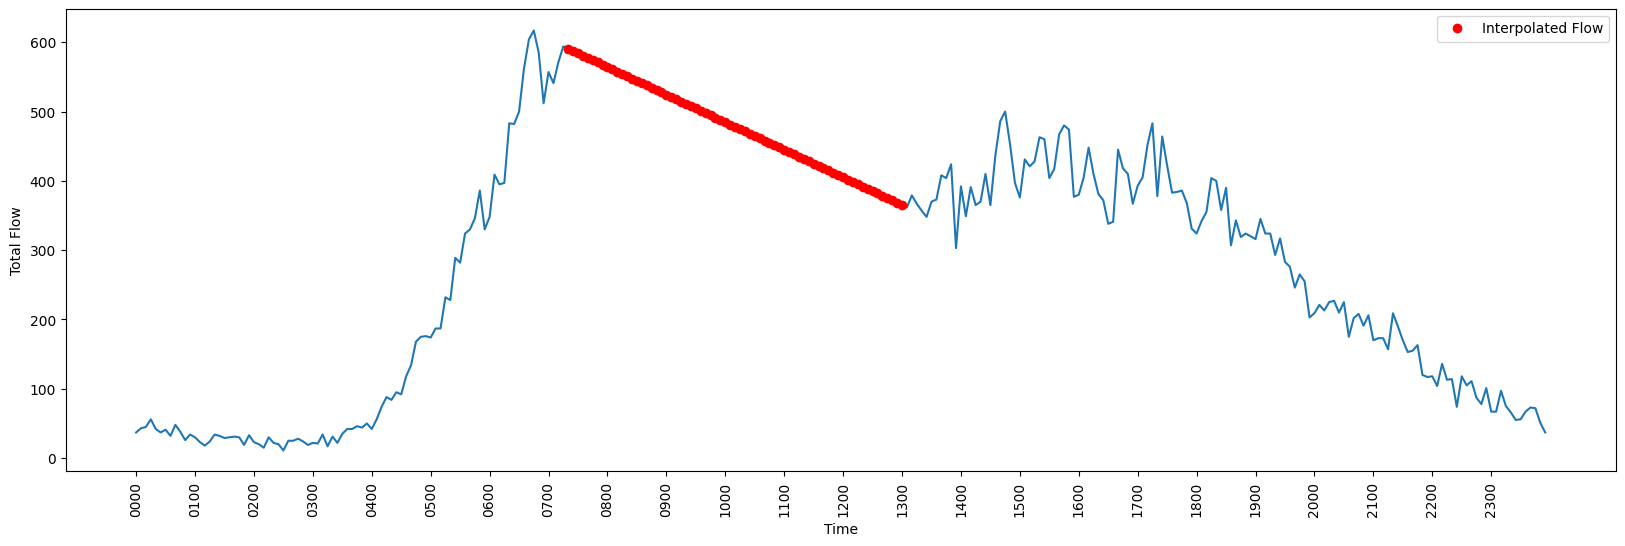

In [247]:
plot_station_flow(df_405N_ML_interpolated, df_405N_ML_merged, 12)

In [276]:
df_a = pd.DataFrame({'PM': [0, 0.1, 0.2, 0.3, 0.4, 0.5]})
df_c = pd.DataFrame({'PM': [0.03, 0.26, 0.35, 0.4, 0.49, 0.65], 'traffic_flow': [100, 200, 300, 400, np.nan, 600]})

# Create a boolean column indicating if the value was interpolated
df_c['interpolated'] = df_c['traffic_flow'].isna()

# Interpolate missing traffic_flow values in df_c
df_c['traffic_flow'] = df_c['traffic_flow'].interpolate()

# Create interval bins
bins = df_a['PM'].tolist() + [np.inf]

# Assign each PM in df_c to an interval in df_a
df_c['PM_range'] = pd.cut(df_c['PM'], bins=bins)

# Group by PM_range and calculate mean traffic_flow and maximum interpolated
traffic_flow_mean = df_c.groupby('PM_range').agg({'traffic_flow': 'mean', 'interpolated': 'max'}).reset_index()

traffic_flow_mean['PM'] = traffic_flow_mean['PM_range'].apply(lambda x: x.left)

# Merge the average traffic_flow and interpolated to df_a
df_final = pd.merge(df_a, traffic_flow_mean, on='PM', how='left')

# Clean up the final dataframe
df_final = df_final.drop(columns='PM_range')
df_final


,PM,traffic_flow,interpolated
0,0.0,100.0,0.0
1,0.1,NaN,NaN
2,0.2,200.0,0.0
3,0.3,350.0,0.0
4,0.4,500.0,1.0
5,0.5,600.0,0.0


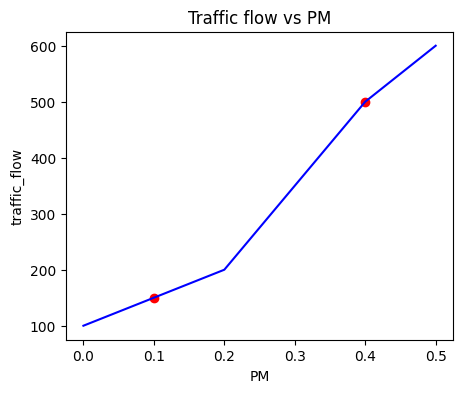

In [282]:
import matplotlib.pyplot as plt

df_d = pd.DataFrame({'PM': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                     'traffic_flow': [100, 150, 200, 350, 500, 600],
                     'interpolated': [False, True, False, False, True, False]})

plt.figure(figsize=(5, 4))
# Plot all points with a line
plt.plot(df_d['PM'], df_d['traffic_flow'], color='blue')

# Overplot the interpolated points with red color
plt.scatter(df_d[df_d['interpolated']]['PM'],
            df_d[df_d['interpolated']]['traffic_flow'],
            color='red')

plt.xlabel('PM')
plt.ylabel('traffic_flow')
plt.title('Traffic flow vs PM')
plt.show()

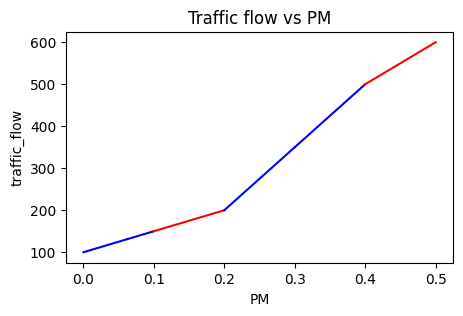

In [285]:
import matplotlib.pyplot as plt

df_d = pd.DataFrame({'PM': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                     'traffic_flow': [100, 150, 200, 350, 500, 600],
                     'interpolated': [False, True, False, False, True, False]})

plt.figure(figsize=(5, 3))

# Loop over each segment
for i in range(len(df_d['PM']) - 1):
    x = df_d['PM'].iloc[i:i+2]
    y = df_d['traffic_flow'].iloc[i:i+2]

    # If the current point is interpolated, the line to the next point is red, else blue
    color = 'red' if df_d['interpolated'].iloc[i] else 'blue'
    plt.plot(x, y, color=color)

plt.xlabel('PM')
plt.ylabel('traffic_flow')
plt.title('Traffic flow vs PM')
plt.show()

# Postmile data

- X, Y are in EPSG:3857 format
- Convert to EPSG:4326 format as X is lat, Y is long

In [295]:
RAW_POSTMILE_PATH = 'raw_data/SHN_Postmiles_Tenth.csv'
pmcols_to_import = [0, 1, 3, 8, 10, 12, 16]
pm_df = pd.read_csv(RAW_POSTMILE_PATH, usecols=pmcols_to_import)

In [296]:
pm_df.dtypes

X            float64
Y            float64
Route          int64
District       int64
PM           float64
PMc           object
AlignCode     object
dtype: object

In [294]:
pm_df['AlignCode'].unique()

array(['Left', 'Left Independent', 'Right', 'Right Independent'],
      dtype=object)

In [300]:
pm_df[(pm_df['District']==12) & (pm_df['Route']==55) & (pm_df['AlignCode']=='Right')].sort_values('X')

,X,Y,Route,District,PM,PMc,AlignCode
115532,-1.312789e+07,3.977852e+06,55,12,0.170000,0.17,Right
115531,-1.312788e+07,3.977902e+06,55,12,0.200000,0.2,Right
116604,-1.312782e+07,3.978096e+06,55,12,0.300000,0.3,Right
117293,-1.312775e+07,3.978268e+06,55,12,0.400000,0.4,Right
115530,-1.312771e+07,3.978452e+06,55,12,0.500000,0.5,Right
...,...,...,...,...,...,...,...
115375,-1.311683e+07,4.007633e+06,55,12,17.600000,17.6,Right
115373,-1.311683e+07,4.007634e+06,55,12,17.600000,R17.6,Right
115372,-1.311668e+07,4.007752e+06,55,12,17.700001,R17.7,Right
117787,-1.311653e+07,4.007813e+06,55,12,17.799999,R17.8,Right


In [301]:
-1.312775e+07,3.978268e+06

-9149482.0

In [ ]:
from pyproj import Proj, transform

in_proj = Proj(init='epsg:3857')  # Input coordinate system (Web Mercator)
out_proj = Proj(init='epsg:4326')  # Output coordinate system (WGS84)

x = -13719301.5307  # Original x-coordinate
y = 4652531.143  # Original y-coordinate

longitude, latitude = transform(in_proj, out_proj, x, y)

print(f'Latitude: {latitude}, Longitude: {longitude}')